In [1]:
import re
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import numpy as np
import tensorflow as tf

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gabriel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train['Text'] = train['Text'].str.lower()
train['Text'] = train['Text'].str.replace('[^\w\s]', '')
train['Text'] = train['Text'].str.replace('[\d]', '')

stop = stopwords.words('english')
train['Text'] = train['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


test['Text'] = test['Text'].str.lower()
test['Text'] = test['Text'].str.replace('[^\w\s]', '')
test['Text'] = test['Text'].str.replace('[\d]', '')

test['Text'] = test['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17272\2729641344.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['Text'] = train['Text'].str.replace('[^\w\s]', '')
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17272\2729641344.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['Text'] = train['Text'].str.replace('[\d]', '')
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17272\2729641344.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  test['Text'] = test['Text'].str.replace('[^\w\s]', '')
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_17272\2729641344.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  test['Text'] = test['Text'].str.replace('[\d]', '')


In [3]:
def lemmatize(text, stem=False):
  # Empty list created to store final tokens
  tokens = []
  for token in text.split():
    # check if the token is a stop word or not
    if token not in stop:
      if stem:
        # Pass to lemmatizer
        tokens.append(wordnet_lemmatizer(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [4]:
%%time
train['Text'] = train['Text'].apply(lambda x: lemmatize(x))
test['Text'] = test['Text'].apply(lambda x: lemmatize(x))

CPU times: total: 17.8 s
Wall time: 17.8 s


In [5]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

tokenizer.fit_on_texts(train['Text'][:150000])
word_index = tokenizer.word_index

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 119856


In [7]:

embeddings_index = {}
with open("glove.6B.300d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_index[word] = vector
f.close()
print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Splitting the data into training and testing sets
train_data, test_data = train_test_split(train, test_size=0.2,random_state=16)
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

from keras_preprocessing.sequence import pad_sequences
# The tokens are converted into sequences and then passed to the pad_sequences() function
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data['Text']),maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data['Text']),maxlen = 30)


labels = ['Negative', 'Positive']
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train['Sentiment'].to_list())
y_train = encoder.transform(train_data['Sentiment'].to_list())
y_test = encoder.transform(test_data['Sentiment'].to_list())
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Train Data size: 838860
Test Data size: 209715


In [9]:
# creating an matrix with zeroes of shape vocab x embedding dimension
embedding_matrix = np.zeros((vocab_size, 300))
# Iterate through word, index in the dictionary
for word, i in word_index.items():
    # extract the corresponding vector for the vocab indice of same word
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Storing it in a matrix
        embedding_matrix[i] = embedding_vector

In [10]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,300,weights=[embedding_matrix],
                                          input_length=30,trainable=False)

In [11]:
# Import various layers needed for the architecture from keras
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, GlobalMaxPool1D
from tensorflow.keras.callbacks import ModelCheckpoint

# The Input layer 
sequence_input = Input(shape=(30,), dtype='int32')
# Inputs passed to the embedding layer
embedding_sequences = embedding_layer(sequence_input)

# dropout and conv layer 
x = SpatialDropout1D(0.1)(embedding_sequences)

x = Conv1D(64, 5, activation='relu')(x)

x = GlobalMaxPool1D(keepdims=True)(x)

# Passed on to the LSTM layer
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)

x = Dense(8, activation='relu')(x)

# Passed on to activation layer to get final output
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [12]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           35956800  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 global_max_pooling1d (Globa  (None, 1, 64)            0         
 lMaxPooling1D)                                                  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048 

In [13]:

from keras.callbacks import ModelCheckpoint
import os

output_dir = 'model_output/conv'
modelcheckpoint = ModelCheckpoint(filepath=output_dir+'/weights.{epoch:02d}.hdf5')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
from tensorflow.keras.optimizers import Adam    
model.compile(optimizer=Adam(learning_rate=0.05), loss='binary_crossentropy',metrics=['accuracy'])


In [14]:
training = model.fit(x_train[:150000], y_train[:150000], batch_size=512, epochs=10,
                    validation_data=(x_test[:40000], y_test[:40000]), callbacks=[modelcheckpoint])

Epoch 1/10
293/293 [==============================] - 18s 43ms/step - loss: 0.4945 - accuracy: 0.7768 - val_loss: 0.4594 - val_accuracy: 0.7923
Epoch 2/10
293/293 [==============================] - 12s 40ms/step - loss: 0.4602 - accuracy: 0.7922 - val_loss: 0.4502 - val_accuracy: 0.7988
Epoch 3/10
293/293 [==============================] - 12s 41ms/step - loss: 0.4574 - accuracy: 0.7952 - val_loss: 0.4702 - val_accuracy: 0.7947
Epoch 4/10
293/293 [==============================] - 12s 41ms/step - loss: 0.4682 - accuracy: 0.7905 - val_loss: 0.4786 - val_accuracy: 0.7829
Epoch 5/10
293/293 [==============================] - 12s 41ms/step - loss: 0.4702 - accuracy: 0.7897 - val_loss: 0.4634 - val_accuracy: 0.7930
Epoch 6/10
293/293 [==============================] - 12s 41ms/step - loss: 0.4646 - accuracy: 0.7892 - val_loss: 0.4593 - val_accuracy: 0.7916
Epoch 7/10
293/293 [==============================] - 12s 41ms/step - loss: 0.4626 - accuracy: 0.7902 - val_loss: 0.4595 - val_accuracy:

In [15]:
def predict_tweet_sentiment(score):
    return 1 if score>0.5 else 0
scores = model.predict(x_test, verbose=1, batch_size=512)
model_predictions = [predict_tweet_sentiment(score) for score in scores]

410/410 [==============================] - 6s 12ms/step


In [16]:
from sklearn.metrics import classification_report
print(classification_report(list(test_data['Sentiment']), model_predictions))

              precision    recall  f1-score   support

           0       0.81      0.95      0.88    160196
           1       0.64      0.28      0.39     49519

    accuracy                           0.79    209715
   macro avg       0.72      0.62      0.63    209715
weighted avg       0.77      0.79      0.76    209715



In [17]:
import sklearn.metrics
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# In my case it was the seventh one: 'weights.07.hdf5'
model.load_weights(output_dir+'/weights.07.hdf5')
y_hat = model.predict_on_batch(x_test)
pct_auc = roc_auc_score(y_test, y_hat) * 100
print('{:0.2f}'.format(pct_auc))

76.84


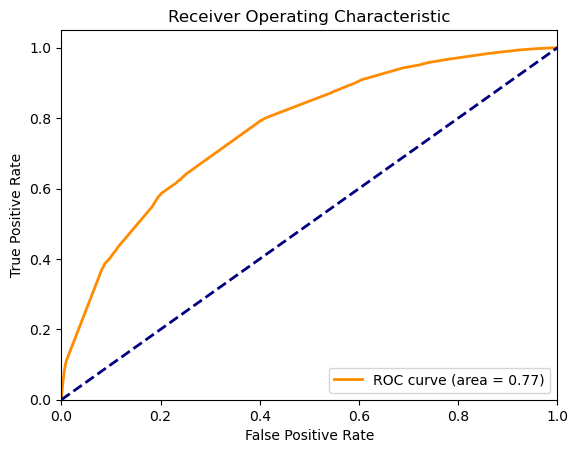

In [18]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_hat)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()